# Image shortest path

This notebook showes the closest images to a given one.

### Import Variables

In [55]:
%matplotlib inline
import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image
from sklearn.manifold import TSNE
from tqdm import tqdm

### Parse all images in custom folder, saves their color and path into the data array

See: `Save images from Wikidata.ipynb` to create a folder containing images from Wikidata.

In [56]:
data = []
folder = '../assets/wikidata_crop/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (10,10))
        image = image.flatten()
        data.append([image, folder + filename])

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 680.74it/s]


### Training

In [57]:
features, images  = zip(*data)

In [60]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=50)
pca.fit(features)
pca_features = pca.transform(features)

In [61]:
len(pca_features), pca_features

(483,
 array([[ 404.7190457 , -281.63885889, -284.46583822, ...,  -22.59784539,
          -28.32236222,   32.0582221 ],
        [ 355.26044962,  -44.9764598 ,   74.01006406, ...,   -9.06944718,
           18.72172419,    6.6646237 ],
        [-344.98012914,  -16.20526326,   29.90274481, ...,  -37.20485421,
           -6.94037401,  -19.50450147],
        ...,
        [-263.6347105 ,   -3.40545915,  -84.31752533, ...,   -2.04067779,
          -35.77077924,  -34.23623269],
        [  26.09973106,  349.62910715,    8.71969428, ...,   20.67365712,
           -8.66019996,  -46.32975953],
        [ 481.05605551,  379.13335288,  -42.21587671, ...,   20.55953211,
            7.89000006,  -20.40469825]]))

### Saves the model

In [62]:
import os
ids = [ os.path.basename(os.path.splitext(x)[0]) for x in images ]

In [64]:
import os
import json
import pandas as pd

model_path = "../data/model.json"

data = [{"id":name, "feature":[pd.Series(feature).to_json(orient='values')]} for name, feature in zip(ids, pca_features)]

with open(model_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved model to %s" % model_path)

saved model to ../data/model.json


### Nearest neighbors

In [65]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

Calculate the nearest neighbors and creates a graph from that

In [66]:
kNN = 5

graph = igraph.Graph(directed=True)
graph.add_vertices(len(images))

for i in tqdm(range(len(images))):
    distances = [ distance.cosine(pca_features[i], feat) for feat in pca_features ]
    idx_kNN = sorted(range(len(distances)), key=lambda k: distances[k])[1:kNN+1]
    
    for j in idx_kNN:
        graph.add_edge(i, j, weight=distances[j])
        

100%|█████████████████████████████████████████| 483/483 [00:05<00:00, 89.63it/s]


### Test the model

In [67]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(images[idx])
        img = img.convert('RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [98]:
idx1 = int(len(images) * random.random())
idx2 = int(len(images) * random.random())

In [99]:
path = graph.get_shortest_paths(idx1,idx2, output='vpath', weights='weight')[0]

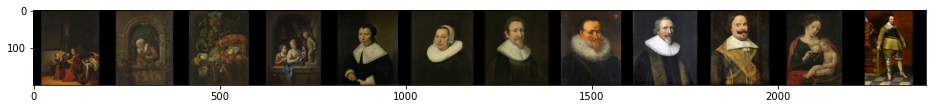

In [100]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

results_image = get_concatenated_images(path, 200)
plt.figure(figsize = (16,12))
imshow(results_image)